# Machine Learning model training

# Pulling the data

In [1]:
import psycopg2
import pandas as pd
from psycopg2 import sql, Error
from datetime import datetime, timedelta
from utils.logger import get_logger

logger = get_logger("pull_data.py")

def load_tables_to_dataframes(host, port, database, username, password):
    conn = None
    dataframes = {}

    today = datetime.today()
    price_cutoff = today - timedelta(days=200)
    sentiment_cutoff = today - timedelta(days=180)
    greed_cutoff = today - timedelta(days=180)

    try:
        logger.info("Connecting to PostgreSQL database...")
        conn = psycopg2.connect(
            host=host,
            port=port,
            dbname=database,
            user=username,
            password=password
        )
        logger.info("✅ Database connection established successfully.")

        queries = {
            "historical_price": f"""
                SELECT * FROM historical_price
                WHERE time >= '{price_cutoff.strftime('%Y-%m-%d')}'
            """,
            "news_sentiment": f"""
                SELECT * FROM news_sentiment
                WHERE time >= '{sentiment_cutoff.strftime('%Y-%m-%d')}'
            """,
            "fear_greed_index": f"""
                SELECT * FROM fear_greed_index
                WHERE time >= '{greed_cutoff.strftime('%Y-%m-%d')}'
            """
        }

        for name, query in queries.items():
            try:
                logger.info(f"Pulling `{name}` data...")
                df = pd.read_sql_query(query, conn)
                dataframes[name] = df
                logger.info(f"✅ Loaded `{name}` ({len(df):,} rows, {len(df.columns)} columns)")
            except Exception as e:
                logger.error(f"❌ Failed to load `{name}`: {e}", exc_info=True)

    except Error as e:
        logger.error(f"❌ Database connection or query error: {e}", exc_info=True)
        raise

    except Exception as e:
        logger.error(f"❌ Unexpected error during data loading: {e}", exc_info=True)
        raise

    finally:
        if conn:
            conn.close()
            logger.info("🔒 Database connection closed.")

    return dataframes


In [2]:
from configs.config import DB_CONFIG

HOST= "localhost"
PORT=DB_CONFIG["port"]
USER=DB_CONFIG["user"]
PASS=DB_CONFIG["password"]
DB_NAME = DB_CONFIG["dbname"]

dataframes = load_tables_to_dataframes(
    HOST,
    PORT,
    DB_NAME,
    USER,
    PASS
)

2025-11-09 03:46:19 | 🟢 INFO | pull_data.py | Connecting to PostgreSQL database...
2025-11-09 03:46:19 | 🟢 INFO | pull_data.py | ✅ Database connection established successfully.
2025-11-09 03:46:19 | 🟢 INFO | pull_data.py | Pulling `historical_price` data...


C:\Users\leeee\AppData\Local\Temp\ipykernel_35448\170440289.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


2025-11-09 03:46:22 | 🟢 INFO | pull_data.py | ✅ Loaded `historical_price` (286,985 rows, 6 columns)
2025-11-09 03:46:22 | 🟢 INFO | pull_data.py | Pulling `news_sentiment` data...


C:\Users\leeee\AppData\Local\Temp\ipykernel_35448\170440289.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


2025-11-09 03:46:22 | 🟢 INFO | pull_data.py | ✅ Loaded `news_sentiment` (11,091 rows, 6 columns)
2025-11-09 03:46:22 | 🟢 INFO | pull_data.py | Pulling `fear_greed_index` data...
2025-11-09 03:46:22 | 🟢 INFO | pull_data.py | ✅ Loaded `fear_greed_index` (180 rows, 3 columns)
2025-11-09 03:46:22 | 🟢 INFO | pull_data.py | 🔒 Database connection closed.


C:\Users\leeee\AppData\Local\Temp\ipykernel_35448\170440289.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [3]:
# For the loaded dataframes:
historical_price = dataframes['historical_price']      # 6 months from 2025-06 onwards
news_sentiment = dataframes['news_sentiment']          # full table
fear_greed = dataframes['fear_greed_index']            # 6 months from 20

historical_price = historical_price.sort_values("time")
news_sentiment = news_sentiment.sort_values("time")
fear_greed = fear_greed.sort_values("time")

#### Data analysis and visualisation

In [4]:
# Get max and min for time columns
price_time_max = historical_price['time'].max()
price_time_min = historical_price['time'].min()

sentiment_time_max = news_sentiment['time'].max()
sentiment_time_min = news_sentiment['time'].min()

greed_time_max = fear_greed['time'].max()
greed_time_min = fear_greed['time'].min()

print(f"Historical Price - Min: {price_time_min}, Max: {price_time_max}")
print(f"News Sentiment - Min: {sentiment_time_min}, Max: {sentiment_time_max}")
print(f"Fear Greed - Min: {greed_time_min}, Max: {greed_time_max}")

Historical Price - Min: 2025-04-23 00:00:00+00:00, Max: 2025-11-08 07:04:00+00:00
News Sentiment - Min: 2025-05-14 19:18:01+00:00, Max: 2025-11-08 06:29:46+00:00
Fear Greed - Min: 2025-05-13 00:00:00+00:00, Max: 2025-11-08 00:00:00+00:00


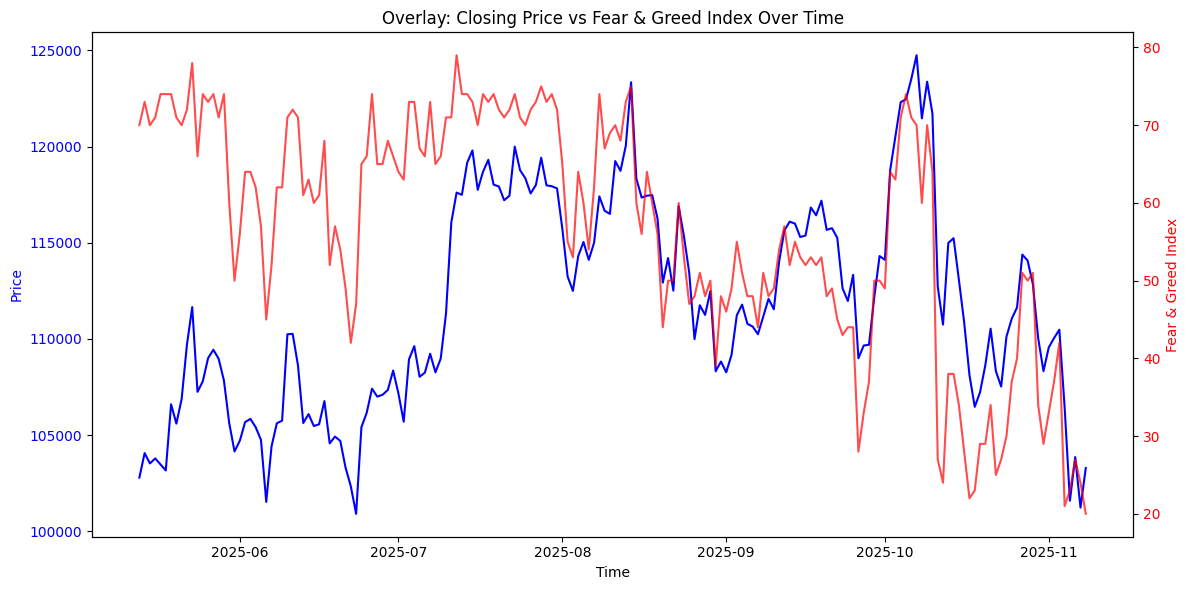

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure time columns are datetime
historical_price['time'] = pd.to_datetime(historical_price['time'])
fear_greed['time'] = pd.to_datetime(fear_greed['time'])

# Merge datasets on overlapping time values
merged_df = pd.merge(historical_price, fear_greed, on='time', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot closing price on left y-axis
ax1.plot(merged_df['time'], merged_df['close'], color='blue', label='Closing Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Fear & Greed Index on right y-axis
ax2 = ax1.twinx()
ax2.plot(merged_df['time'], merged_df['value'], color='red', label='Fear & Greed Index', alpha=0.7)
ax2.set_ylabel('Fear & Greed Index', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Overlay: Closing Price vs Fear & Greed Index Over Time')
fig.tight_layout()
plt.show()


# Preprocessing News Sentiment

#### Data analysis and visualisation

In [6]:
import pandas as pd
import numpy as np

def analyze_bin_distribution(df: pd.DataFrame, freq: str) -> dict:
    """
    Analyze article distribution for a given bin frequency
    
    Returns statistics about bin efficiency
    """
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    # Resample into bins
    bins = df.resample(freq)
    
    # Count articles per bin
    bin_counts = bins.size()  # Returns Series with bin start times as index
    
    # Calculate metrics
    total_bins = len(bin_counts)
    non_empty_bins = (bin_counts > 0).sum()
    empty_bins = total_bins - non_empty_bins
    total_articles = bin_counts.sum()
    
    # Efficiency metrics
    avg_articles_per_bin = total_articles / total_bins if total_bins > 0 else 0
    avg_articles_per_nonempty_bin = total_articles / non_empty_bins if non_empty_bins > 0 else 0
    empty_bin_ratio = empty_bins / total_bins if total_bins > 0 else 0
    pct_empty = empty_bin_ratio * 100  # ← NEW: percentage as 0-100
    
    # Distribution percentiles
    non_empty_counts = bin_counts[bin_counts > 0]
    if len(non_empty_counts) > 0:
        percentiles = np.percentile(non_empty_counts, [25, 50, 75, 90, 95])
    else:
        percentiles = [0, 0, 0, 0, 0]
    
    return {
        'frequency': freq,
        'total_bins': total_bins,
        'non_empty_bins': non_empty_bins,
        'empty_bins': empty_bins,
        'empty_bin_ratio': empty_bin_ratio,
        'pct_empty': pct_empty,
        'avg_articles_per_bin': avg_articles_per_bin,
        'avg_articles_per_nonempty_bin': avg_articles_per_nonempty_bin,
        'p25_articles': percentiles[0],
        'p50_articles': percentiles[1],
        'p75_articles': percentiles[2],
        'p90_articles': percentiles[3],
        'p95_articles': percentiles[4],
        'max_articles_in_bin': non_empty_counts.max() if len(non_empty_counts) > 0 else 0
    }


def find_optimal_bin_size(
    df: pd.DataFrame,
    frequencies: list = None
) -> pd.DataFrame:
    """
    Evaluate multiple bin frequencies and return comparison DataFrame
    
    Default frequencies cover common crypto trading intervals
    """
    if frequencies is None:
        frequencies = [
            '1min',   # 1 minute
            '2min',   # 2 minutes  
            '3min',   # 3 minutes
            '5min',   # 5 minutes
            '10min',  # 10 minutes
            '15min',  # 15 minutes
            '30min',  # 30 minutes
            '1h',   # 1 hour
            '2h',   # 2 hours
            '4h',   # 4 hours
            '6h',   # 6 hours
            '12h',  # 12 hours
            '1d'    # 1 day
        ]
    
    results = []
    for freq in frequencies:
        try:
            stats = analyze_bin_distribution(df, freq)
            results.append(stats)
        except Exception as e:
            print(f"Failed for frequency {freq}: {e}")
            continue
    
    return pd.DataFrame(results)



bin_analysis = find_optimal_bin_size(news_sentiment)
print(bin_analysis.to_string(index=False))

frequency  total_bins  non_empty_bins  empty_bins  empty_bin_ratio  pct_empty  avg_articles_per_bin  avg_articles_per_nonempty_bin  p25_articles  p50_articles  p75_articles  p90_articles  p95_articles  max_articles_in_bin
     1min      255552           10296      245256         0.959711  95.971074              0.043400                       1.077214          1.00           1.0           1.0           1.0          2.00                    6
     2min      127776            9974      117802         0.921942  92.194152              0.086800                       1.111991          1.00           1.0           1.0           1.0          2.00                    6
     3min       85184            9691       75493         0.886235  88.623450              0.130201                       1.144464          1.00           1.0           1.0           2.0          2.00                    6
     5min       51111            9203       41908         0.819941  81.994091              0.216998             

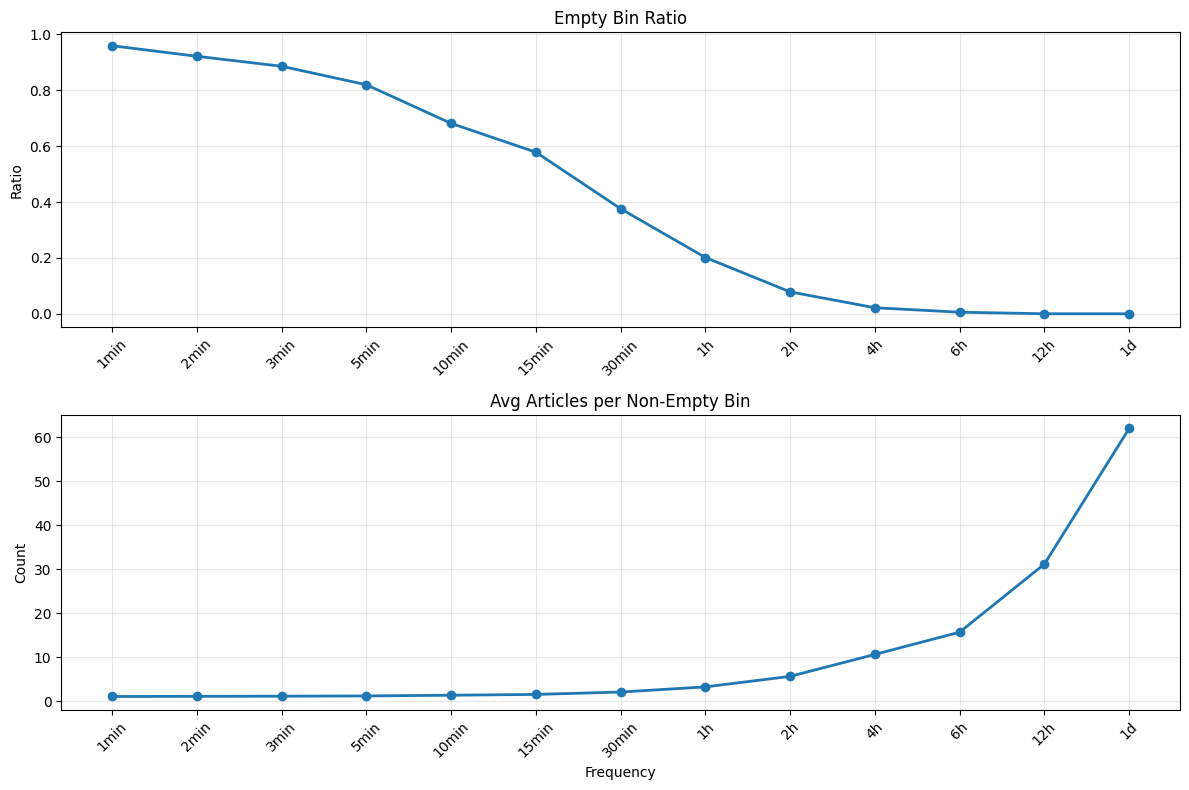

In [7]:
import matplotlib.pyplot as plt

def plot_bin_analysis(bin_df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column
    
    # Empty bin ratio (top plot)
    axes[0].plot(bin_df['frequency'], bin_df['empty_bin_ratio'], 'o-', linewidth=2, markersize=6)
    axes[0].set_title('Empty Bin Ratio')
    axes[0].set_ylabel('Ratio')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Avg articles per non-empty bin (bottom plot)
    axes[1].plot(bin_df['frequency'], bin_df['avg_articles_per_nonempty_bin'], 'o-', linewidth=2, markersize=6)
    axes[1].set_title('Avg Articles per Non-Empty Bin')
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('Frequency')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_bin_analysis(bin_analysis)

#### Preprocessing

In [8]:
news_sentiment

,time,article_id,sentiment_score,sentiment_label,confidence,model_used
4580,2025-05-14 19:18:01+00:00,591,-0.919068,negative,0.950054,finbert
4576,2025-05-14 19:18:04+00:00,332,0.130168,neutral,0.834354,finbert
4582,2025-05-14 19:59:05+00:00,647,0.015572,neutral,0.926071,finbert
4586,2025-05-14 20:24:00+00:00,683,0.684489,positive,0.838869,finbert
4589,2025-05-14 20:30:05+00:00,761,0.703160,positive,0.847584,finbert
...,...,...,...,...,...,...
147,2025-11-08 02:32:00+00:00,10790,0.008554,neutral,0.948107,finbert
143,2025-11-08 05:16:05+00:00,10770,0.023488,neutral,0.958384,finbert
59,2025-11-08 06:05:29+00:00,61,0.909106,positive,0.934353,finbert
119,2025-11-08 06:29:11+00:00,121,-0.881601,negative,0.933371,finbert


In [9]:
def drop_columns_news_sentiment(news_sentiment):
    news_sentiment = news_sentiment.drop(columns=["model_used", "article_id"])
    return news_sentiment

news_sentiment = drop_columns_news_sentiment(news_sentiment)

#### Data Binning

- because news data is sporadic, and the time interval is continuous, we bin into discrete interval like 30mins-1hr and aggregate through mean for sentiments, weighted average for confidence, and mode for labels
- we measure the max consecutive period of not having any news sentiment, as well as on average. 

<!-- - we see that on average, we have no news sentiment for every 30-45mins, which is still reasonable.
- the max is 9.5hours of no news sentiment, which could either mean means data collection issues.
- to handle natural lack of news, we propagate sentiments through linear regression, on the basis that sentiment is temporal in nature which makes interpolation sound
- however we will only interpolate if the news sentiment is within reasonable missingness, and fill with 0 / neutral if the missingness points to data collection issue -->

#### Feature engineering

In [10]:
def basic_sentiment_stats(group: pd.DataFrame) -> pd.Series:
    """Compute basic statistics for sentiment scores in a time bucket"""
    return pd.Series({
        'article_count': len(group),
        'sentiment_mean': group['sentiment_score'].mean(),
        'sentiment_median': group['sentiment_score'].median(),
        'sentiment_std': group['sentiment_score'].std(),
        'confidence_mean': group['confidence'].mean(),
        'confidence_std': group['confidence'].std()
    })


def weighted_sentiment_features(group: pd.DataFrame) -> pd.Series:
    """Compute confidence-weighted sentiment metrics"""
    weights = group['confidence']
    total_weight = weights.sum()
    
    if total_weight == 0 or len(group) == 0:
        return pd.Series({
            'weighted_sentiment': np.nan,
            'weighted_std': np.nan,
            'confidence_weighted_count': 0.0
        })
    
    # Weighted sentiment score
    weighted_sentiment = (group['sentiment_score'] * weights).sum() / total_weight
    
    # Weighted standard deviation
    diff = group['sentiment_score'] - weighted_sentiment
    weighted_variance = (weights * (diff ** 2)).sum() / total_weight
    weighted_std = np.sqrt(weighted_variance) if weighted_variance > 0 else 0.0
    
    return pd.Series({
        'weighted_sentiment': weighted_sentiment,
        'weighted_std': weighted_std,
        'confidence_weighted_count': total_weight  # Sum of confidences
    })


def polarity_ratios(group: pd.DataFrame) -> pd.Series:
    """Compute ratios of positive/negative/neutral articles"""
    if len(group) == 0:
        return pd.Series({
            'positive_ratio': 0.0,
            'negative_ratio': 0.0,
            'neutral_ratio': 1.0,
            'polarized_ratio': 0.0
        })
    
    # Define thresholds
    POS_THRESH = 0.05
    NEG_THRESH = -0.05
    HIGH_CONF_THRESH = 0.7
    
    # Count polarized articles (high confidence + strong sentiment)
    polarized = group[
        (group['confidence'] >= HIGH_CONF_THRESH) &
        (abs(group['sentiment_score']) >= 0.5)
    ]
    
    return pd.Series({
        'positive_ratio': (group['sentiment_score'] > POS_THRESH).mean(),
        'negative_ratio': (group['sentiment_score'] < NEG_THRESH).mean(),
        'neutral_ratio': ((group['sentiment_score'] >= NEG_THRESH) & 
                          (group['sentiment_score'] <= POS_THRESH)).mean(),
        'polarized_ratio': len(polarized) / len(group)
    })


def conflict_features(group: pd.DataFrame) -> pd.Series:
    """Detect sentiment conflict/disagreement in time bucket"""
    if len(group) < 2:
        return pd.Series({
            'conflict_score': 0.0,
            'max_disagreement': 0.0,
            'is_high_conflict': False
        })
    
    # High conflict = high volatility + high confidence articles exist
    volatility = group['sentiment_score'].std()
    high_conf_articles = group[group['confidence'] > 0.6]
    
    conflict_score = volatility * (len(high_conf_articles) / len(group))
    max_disagreement = group['sentiment_score'].max() - group['sentiment_score'].min()
    
    # Binary flag for extreme conflict
    is_high_conflict = (volatility > 0.6) and (len(high_conf_articles) >= 2)
    
    return pd.Series({
        'conflict_score': conflict_score,
        'max_disagreement': max_disagreement,
        'is_high_conflict': is_high_conflict
    })


def volatility_centric_features(group: pd.DataFrame) -> pd.Series:
    if group.empty:
        return pd.Series({
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'article_count': 0,
            'volatility': 0.0,
            'is_conflict': False
        })
    
    weights = group['confidence']
    total_weight = weights.sum()
    
    # Weighted sentiment
    if total_weight == 0:
        weighted_score = group['sentiment_score'].mean()
    else:
        weighted_score = (group['sentiment_score'] * weights).sum() / total_weight
    
    # Volatility = std of raw sentiment scores
    volatility = group['sentiment_score'].std()
    if pd.isna(volatility):
        volatility = 0.0
    
    avg_conf = weights.mean()
    is_conflict = (volatility > 0.5) and (avg_conf > 0.6)
    
    return pd.Series({
        'sentiment_score': weighted_score,
        'confidence': avg_conf,
        'article_count': len(group),
        'volatility': volatility,
        'is_conflict': is_conflict
    })



In [11]:
def aggregate_sentiment_features(
    df: pd.DataFrame,
    freq: str = '1h',
    feature_functions: list = None
) -> pd.DataFrame:
    if feature_functions is None:
        feature_functions = [
            basic_sentiment_stats,
            weighted_sentiment_features,
            polarity_ratios,
            conflict_features,
            volatility_centric_features
        ]
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time').sort_index()
    
    buckets = df.resample(freq)
    
    results = []
    for timestamp, group in buckets:
        features = {'time': timestamp}
        for func in feature_functions:
            try:
                func_result = func(group)
                features.update(func_result.to_dict())
            except Exception as e:
                # Fallback for empty or failed groups
                try:
                    empty_df = pd.DataFrame({'sentiment_score': [], 'confidence': []})
                    placeholder = {col: np.nan for col in func(empty_df).index}
                except Exception:
                    placeholder = {}
                features.update(placeholder)
        results.append(features)
    
    result_df = pd.DataFrame(results)
    
    # Fill NaN values for missing data  --> treat as neutral
    result_df = result_df.fillna({
        'article_count': 0,                # Fill NaN article count with 0
        'positive_ratio': 0,               # Fill NaN positive ratio with 0
        'negative_ratio': 0,               # Fill NaN negative ratio with 0
        'neutral_ratio': 1,                # Fill NaN neutral ratio with 1
        'polarized_ratio': 0.0,            # Fill NaN polarized ratio with 0
        'is_high_conflict': False,         # Fill NaN high conflict flag with False
        'is_conflict': False,              # Fill NaN conflict flag with False
        'confidence_weighted_count': 0.0,  # Fill NaN confidence-weighted count with 0
        'volatility': 0.0,                 # Fill NaN volatility with 0
        'sentiment_score': 0.0,            # Fill NaN sentiment score with 0
        'confidence': 0.0,                 # Fill NaN confidence with 0
        'sentiment_mean': 0.0,             # Fill NaN sentiment mean with 0
        'sentiment_median': 0.0,           # Fill NaN sentiment median with 0
        'sentiment_std': 0.0,              # Fill NaN sentiment std with 0
        'confidence_mean': 0.0,            # Fill NaN confidence mean with 0
        'confidence_std': 0.0,             # Fill NaN confidence std with 0
        'weighted_sentiment': 0.0,         # Fill NaN weighted sentiment with 0
        'weighted_std': 0.0                # Fill NaN weighted std with 0
    })

    # Additional handling for specific categorical columns
    result_df['positive_ratio'].fillna(0, inplace=True)
    result_df['negative_ratio'].fillna(0, inplace=True)
    result_df['neutral_ratio'].fillna(1, inplace=True)  # Fill missing neutral ratio with 1 (neutral)

    result_df = result_df.reset_index()  # moves 'time' back to a column
    result_df = result_df.drop(columns=["index"])
    return result_df


In [12]:
sentiment_1h = aggregate_sentiment_features(news_sentiment, freq='1h')
sentiment_1h.head()

C:\Users\leeee\AppData\Local\Temp\ipykernel_35448\2261948346.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['positive_ratio'].fillna(0, inplace=True)
C:\Users\leeee\AppData\Local\Temp\ipykernel_35448\2261948346.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

,time,article_count,sentiment_mean,sentiment_median,sentiment_std,confidence_mean,confidence_std,weighted_sentiment,weighted_std,confidence_weighted_count,...,negative_ratio,neutral_ratio,polarized_ratio,conflict_score,max_disagreement,is_high_conflict,sentiment_score,confidence,volatility,is_conflict
0,2025-05-14 19:00:00+00:00,3,-0.257776,0.015572,0.575555,0.903493,0.061065,-0.276754,0.474107,2.710479,...,0.333333,0.333333,0.333333,0.575555,1.049236,False,-0.276754,0.903493,0.575555,True
1,2025-05-14 20:00:00+00:00,3,0.704580,0.703160,0.020838,0.837756,0.010430,0.704472,0.016960,2.513267,...,0.000000,0.000000,1.000000,0.020838,0.041604,False,0.704472,0.837756,0.020838,False
2,2025-05-14 21:00:00+00:00,7,-0.139200,-0.007415,0.641303,0.836567,0.141413,-0.161383,0.615942,5.855966,...,0.428571,0.142857,0.428571,0.641303,1.775187,True,-0.161383,0.836567,0.641303,True
3,2025-05-14 22:00:00+00:00,1,-0.926733,-0.926733,0.000000,0.953194,0.000000,-0.926733,0.000000,0.953194,...,1.000000,0.000000,1.000000,0.000000,0.000000,False,-0.926733,0.953194,0.000000,False
4,2025-05-14 23:00:00+00:00,1,0.804545,0.804545,0.000000,0.897332,0.000000,0.804545,0.000000,0.897332,...,0.000000,0.000000,1.000000,0.000000,0.000000,False,0.804545,0.897332,0.000000,False


In [13]:
sentiment_1h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260 entries, 0 to 4259
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   time                       4260 non-null   datetime64[ns, UTC]
 1   article_count              4260 non-null   int64              
 2   sentiment_mean             4260 non-null   float64            
 3   sentiment_median           4260 non-null   float64            
 4   sentiment_std              4260 non-null   float64            
 5   confidence_mean            4260 non-null   float64            
 6   confidence_std             4260 non-null   float64            
 7   weighted_sentiment         4260 non-null   float64            
 8   weighted_std               4260 non-null   float64            
 9   confidence_weighted_count  4260 non-null   float64            
 10  positive_ratio             4260 non-null   float64            
 11  nega

#### Data visualisation and analysis

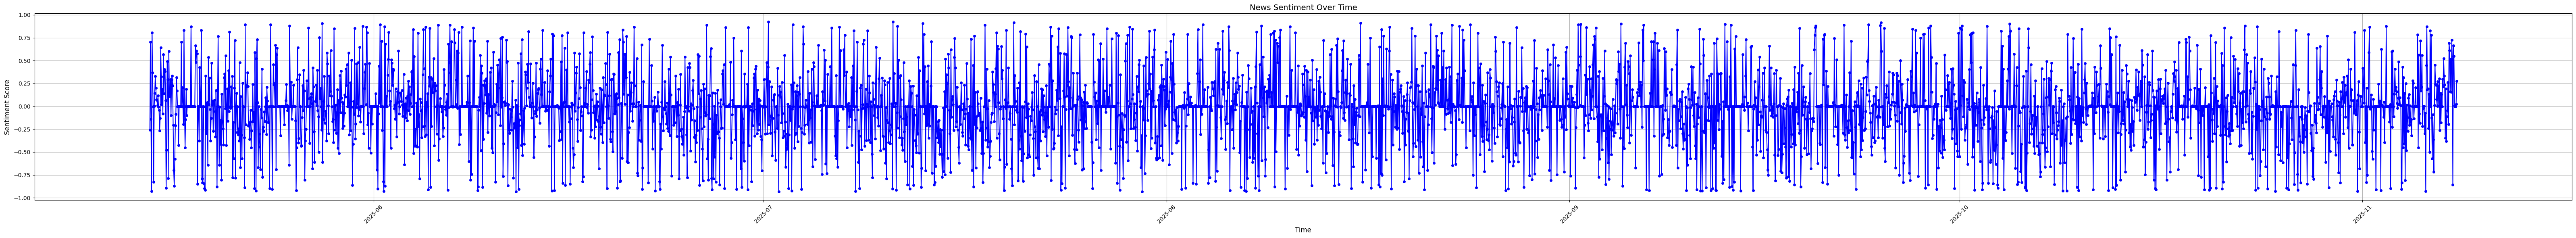

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(64, 6))
plt.plot(sentiment_1h['time'], sentiment_1h['sentiment_mean'], color='blue', marker='o', linestyle='-', markersize=4)

# Adding titles and labels
plt.title('News Sentiment Over Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [15]:
sentiment_1h.describe()

,article_count,sentiment_mean,sentiment_median,sentiment_std,confidence_mean,confidence_std,weighted_sentiment,weighted_std,confidence_weighted_count,positive_ratio,negative_ratio,neutral_ratio,polarized_ratio,conflict_score,max_disagreement,sentiment_score,confidence,volatility
count,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000,4260.000000
mean,2.603521,-0.020655,-0.018676,0.321433,0.647247,0.070564,-0.025827,0.271047,2.109968,0.350075,0.333066,0.316859,0.442546,0.287279,0.654027,-0.025827,0.647247,0.321433
std,2.470742,0.389495,0.438316,0.334156,0.337057,0.079023,0.399555,0.283217,2.016078,0.361117,0.354492,0.411547,0.386346,0.316149,0.691130,0.399555,0.337057,0.334156
min,0.000000,-0.932395,-0.932395,0.000000,0.000000,0.000000,-0.932395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.932395,0.000000,0.000000
25%,1.000000,-0.216278,-0.261376,0.000000,0.637828,0.000000,-0.245714,0.000000,0.690711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.245714,0.637828,0.000000
50%,2.000000,0.000000,0.000000,0.253266,0.793429,0.040789,0.000000,0.194478,1.637677,0.333333,0.285714,0.000000,0.500000,0.185061,0.429384,0.000000,0.793429,0.253266
75%,4.000000,0.159441,0.189729,0.619748,0.867056,0.135808,0.162815,0.541482,3.163022,0.600000,0.500000,0.559524,0.750000,0.539872,1.364110,0.162815,0.867056,0.619748
max,16.000000,0.922632,0.926337,1.301775,0.975675,0.377579,0.922632,0.920487,13.325267,1.000000,1.000000,1.000000,1.000000,1.301775,1.857789,0.922632,0.975675,1.301775


In [16]:
no_articles = sentiment_1h[sentiment_1h['article_count'] == 0]
total_intervals = sentiment_1h.shape[0]
proportion_no_articles = no_articles.shape[0] / total_intervals
proportion_with_articles = 1 - proportion_no_articles

print(f"Proportion of intervals with no articles: {proportion_no_articles:.4f}")
print(f"Proportion of intervals with articles: {proportion_with_articles:.4f}")

Proportion of intervals with no articles: 0.2014
Proportion of intervals with articles: 0.7986


In [17]:
import pandas as pd
import numpy as np

def no_articles_statistics(sentiment_1h):
    # Boolean series where article_count == 0 (no articles)
    no_articles = sentiment_1h['article_count'] == 0

    # Create group IDs for consecutive periods of no articles
    group_id = (~no_articles).cumsum()

    # Sum the consecutive periods of no articles to get their lengths
    runs = no_articles.groupby(group_id).sum()

    # Filter to keep only the "no articles" runs (i.e., where run length > 0)
    no_article_runs = runs[runs > 0]

    # If there are no runs of "no articles", return None or some default values
    if no_article_runs.empty:
        return {
            'longest_run': 0,
            'average_run': 0,
            'std_dev': 0,
            '3sd_above_mean': 0
        }
    
    # Compute statistics for the no-article runs
    longest_run = no_article_runs.max()
    average_run = no_article_runs.mean()
    std_dev = no_article_runs.std()

    # Calculate 3 standard deviations above the mean
    three_sd_above_mean = average_run + 3 * std_dev

    return {
        'longest_run': longest_run,
        'average_run': average_run,
        'std_dev': std_dev,
        '3sd_above_mean': three_sd_above_mean
    }

# Example usage:
# Assuming you have a DataFrame `sentiment_1h` with an 'article_count' column
stats = no_articles_statistics(sentiment_1h)

# Output the results
print(f"Longest period without articles (in intervals): {stats['longest_run']}")
print(f"Average period without articles (in intervals): {stats['average_run']:.2f}")
print(f"Standard deviation of periods without articles (in intervals): {stats['std_dev']:.2f}")
print(f"3 standard deviations above the mean (in intervals): {stats['3sd_above_mean']:.2f}")


Longest period without articles (in intervals): 9
Average period without articles (in intervals): 1.66
Standard deviation of periods without articles (in intervals): 1.29
3 standard deviations above the mean (in intervals): 5.51


# Preprocess Price

#### preprocess

In [18]:
def resample_price(historical_price, interval="1h"):
    historical_price['time'] = pd.to_datetime(historical_price['time'])
    historical_price.set_index('time', inplace=True)

    # Resample to 4-hour candles (OHLCV)
    price_1h = historical_price.resample(interval).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    price_1h.reset_index(inplace=True)
    return price_1h

price_1h = resample_price(historical_price, "1h")

price_1h

,time,open,high,low,close,volume
0,2025-04-23 00:00:00+00:00,93482.0,93921.0,92863.0,92938.0,74.067081
1,2025-04-23 01:00:00+00:00,92947.0,93527.0,92657.0,92687.0,97.915353
2,2025-04-23 02:00:00+00:00,92687.0,93263.0,92658.0,92909.0,39.537192
3,2025-04-23 03:00:00+00:00,92909.0,93216.0,92720.0,93188.0,7.133947
4,2025-04-23 04:00:00+00:00,93200.0,93697.0,93061.0,93696.0,33.077870
...,...,...,...,...,...,...
4779,2025-11-08 03:00:00+00:00,102796.0,103224.0,102535.0,102553.0,68.665143
4780,2025-11-08 04:00:00+00:00,102538.0,102783.0,102360.0,102509.0,66.376504
4781,2025-11-08 05:00:00+00:00,102492.0,102679.0,102237.0,102244.0,24.992486
4782,2025-11-08 06:00:00+00:00,102254.0,102463.0,102043.0,102167.0,41.170669


#### Feature Engineering

In [19]:
def add_rolling_features(df, price_col='close', window_days=7, candle_interval_hours=1):
    """
    Adds rolling volatility and return features based on past N days.
    """
    window = int((24 / candle_interval_hours) * window_days)
    df = df.copy()
    df['rolling_volatility'] = df[price_col].pct_change().rolling(window).std()
    df['rolling_return'] = df[price_col].pct_change(window)
    return df


def calculate_rsi(df, column='close', period=14):
    """Calculate the Relative Strength Index (RSI)."""
    delta = df[column].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df


def calculate_macd(df, column='close', short_span=12, long_span=26, signal_span=9):
    """Calculate MACD and Signal Line."""
    short_ema = df[column].ewm(span=short_span, adjust=False).mean()
    long_ema = df[column].ewm(span=long_span, adjust=False).mean()
    
    df['MACD'] = short_ema - long_ema
    df['Signal'] = df['MACD'].ewm(span=signal_span, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal']
    return df


def calculate_bollinger_bands(df, column='close', window=20, num_std=2):
    """Calculate Bollinger Bands."""
    df['SMA'] = df[column].rolling(window=window).mean()
    df['STD'] = df[column].rolling(window=window).std()
    df['UpperBand'] = df['SMA'] + (num_std * df['STD'])
    df['LowerBand'] = df['SMA'] - (num_std * df['STD'])
    return df


def calculate_obv(df, close_col='close', vol_col='volume'):
    """Calculate On-Balance Volume (OBV)."""
    df['OBV'] = 0
    df.loc[df[close_col] > df[close_col].shift(1), 'OBV'] = df[vol_col]
    df.loc[df[close_col] < df[close_col].shift(1), 'OBV'] = -df[vol_col]
    df['OBV'] = df['OBV'].cumsum()
    return df


def calculate_vwap(df, price_col='close', vol_col='volume'):
    """Calculate Volume Weighted Average Price (VWAP)."""
    df['Cum_Volume'] = df[vol_col].cumsum()
    df['Cum_Vol_Price'] = (df[price_col] * df[vol_col]).cumsum()
    df['VWAP'] = df['Cum_Vol_Price'] / df['Cum_Volume']
    return df


def generate_signals(df):
    # RSI signal
    df['RSI_Signal'] = 0
    df.loc[df['RSI'] < 30, 'RSI_Signal'] = 1   # bullish (oversold)
    df.loc[df['RSI'] > 70, 'RSI_Signal'] = -1  # bearish (overbought)

    # MACD signal
    df['MACD_Signal'] = 0
    df.loc[df['MACD'] > df['Signal'], 'MACD_Signal'] = 1
    df.loc[df['MACD'] < df['Signal'], 'MACD_Signal'] = -1

    # Bollinger Band signal
    df['BB_Signal'] = 0
    df.loc[df['close'] < df['LowerBand'], 'BB_Signal'] = 1   # bullish
    df.loc[df['close'] > df['UpperBand'], 'BB_Signal'] = -1  # bearish

    # OBV signal
    df['OBV_Signal'] = 0
    df.loc[df['OBV'] > df['OBV'].shift(1), 'OBV_Signal'] = 1
    df.loc[df['OBV'] < df['OBV'].shift(1), 'OBV_Signal'] = -1

    # VWAP signal
    df['VWAP_Signal'] = 0
    df.loc[df['close'] > df['VWAP'], 'VWAP_Signal'] = 1
    df.loc[df['close'] < df['VWAP'], 'VWAP_Signal'] = -1

    # Combined sentiment from all indicators
    signal_cols = ['RSI_Signal', 'MACD_Signal', 'BB_Signal', 'OBV_Signal', 'VWAP_Signal']
    df['Combined_Score'] = df[signal_cols].sum(axis=1)

    # Normalize to -1, 0, 1 (majority vote style)
    df['Combined_Signal'] = df['Combined_Score'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    return df



def aggregate_price_features(price_1h):
    price_1h = calculate_rsi(price_1h)
    price_1h = calculate_macd(price_1h)
    price_1h = calculate_bollinger_bands(price_1h)
    price_1h = calculate_obv(price_1h)
    price_1h = calculate_vwap(price_1h)
    price_1h = generate_signals(price_1h)
    price_1h = add_rolling_features(price_1h)
    price_1h = price_1h.drop(columns=["Cum_Volume", "Cum_Vol_Price"])
    # price_1h.reset_index(inplace=True)
    # price_1h.drop(columns=["index"])
    return price_1h


price_1h = aggregate_price_features(price_1h)
price_1h

C:\Users\leeee\AppData\Local\Temp\ipykernel_35448\4203535631.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[39.53719182  7.13394725 33.07787028 ... 37.71100273 96.94729555
  0.63423712]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[close_col] > df[close_col].shift(1), 'OBV'] = df[vol_col]


,time,open,high,low,close,volume,RSI,MACD,Signal,MACD_Hist,...,VWAP,RSI_Signal,MACD_Signal,BB_Signal,OBV_Signal,VWAP_Signal,Combined_Score,Combined_Signal,rolling_volatility,rolling_return
0,2025-04-23 00:00:00+00:00,93482.0,93921.0,92863.0,92938.0,74.067081,NaN,0.000000,0.000000,0.000000,...,92938.000000,0,0,0,0,0,0,0,NaN,NaN
1,2025-04-23 01:00:00+00:00,92947.0,93527.0,92657.0,92687.0,97.915353,0.000000,-20.022792,-4.004558,-16.018234,...,92795.097303,1,-1,0,-1,-1,-2,-1,NaN,NaN
2,2025-04-23 02:00:00+00:00,92687.0,93263.0,92658.0,92909.0,39.537192,46.934461,-17.772583,-6.758163,-11.014420,...,92816.387965,0,-1,0,1,1,1,1,NaN,NaN
3,2025-04-23 03:00:00+00:00,92909.0,93216.0,92720.0,93188.0,7.133947,66.622340,6.449348,-4.116661,10.566009,...,92828.512444,0,1,0,1,1,3,1,NaN,NaN
4,2025-04-23 04:00:00+00:00,93200.0,93697.0,93061.0,93696.0,33.077870,80.079365,65.877364,9.882144,55.995220,...,92942.501545,-1,1,0,1,1,2,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,2025-11-08 03:00:00+00:00,102796.0,103224.0,102535.0,102553.0,68.665143,71.053115,344.645066,260.953665,83.691401,...,110932.872320,-1,1,0,-1,-1,-2,-1,0.005018,-0.069147
4780,2025-11-08 04:00:00+00:00,102538.0,102783.0,102360.0,102509.0,66.376504,67.787505,307.424329,270.247798,37.176532,...,110931.004846,0,1,0,-1,-1,-1,-1,0.005017,-0.070070
4781,2025-11-08 05:00:00+00:00,102492.0,102679.0,102237.0,102244.0,24.992486,64.351939,253.619771,266.922192,-13.302421,...,110930.279789,0,-1,0,-1,-1,-3,-1,0.005019,-0.071117
4782,2025-11-08 06:00:00+00:00,102254.0,102463.0,102043.0,102167.0,41.170669,60.646197,202.432499,254.024254,-51.591755,...,110929.075066,0,-1,0,-1,-1,-3,-1,0.005019,-0.070694


# Preprocess Fear and Greed

#### Data Analysis

In [20]:
fear_greed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   time                  180 non-null    datetime64[ns, UTC]
 1   value                 180 non-null    int64              
 2   value_classification  180 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 4.3+ KB


In [21]:
fear_greed.value_counts("value_classification")

value_classification
Greed            100
Neutral           39
Fear              31
Extreme Fear       8
Extreme Greed      2
Name: count, dtype: int64

#### Preprocess

In [22]:
def preprocess_fear_greed(fear_greed):
    fear_greed = fear_greed.rename(columns={
        "value": "fng_index",
        "value_classification": "fng_class"
    })
    
    sentiment_map = {
        "Extreme Fear": -2,
        "Fear": -1,
        "Neutral": 0,
        "Greed": 1,
        "Extreme Greed": 2
    }
    
    fear_greed["fng_sentiment"] = fear_greed["fng_class"].map(sentiment_map)
    fear_greed.drop(columns=["fng_class"], inplace=True)
    return fear_greed

fear_greed = preprocess_fear_greed(fear_greed)
fear_greed

,time,fng_index,fng_sentiment
0,2025-05-13 00:00:00+00:00,70,1
1,2025-05-14 00:00:00+00:00,73,1
2,2025-05-15 00:00:00+00:00,70,1
3,2025-05-16 00:00:00+00:00,71,1
4,2025-05-17 00:00:00+00:00,74,1
...,...,...,...
175,2025-11-04 00:00:00+00:00,21,-2
176,2025-11-05 00:00:00+00:00,23,-2
177,2025-11-06 00:00:00+00:00,27,-1
178,2025-11-07 00:00:00+00:00,24,-2


# Data Preparation

#### Data Preparation + Labels

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def merging_data_sources(price_1h, sentiment_1h, fear_greed):
    # Sort all DataFrames by 'time' (required for merge_asof)
    price_1h = price_1h.sort_values("time").reset_index(drop=True)
    fear_greed = fear_greed.sort_values("time").reset_index(drop=True)
    sentiment_1h = sentiment_1h.sort_values("time").reset_index(drop=True)

    # Step 1: Merge fear_greed into price_1h using backward asof
    price_with_fear = pd.merge_asof(
        price_1h,
        fear_greed,
        on="time",
        direction="backward"
    )

    # Step 2: Left join sentiment_1h on exact 'time' match
    merged = sentiment_1h.merge(
        price_with_fear,
        on="time",
        how="left"
    )

    return merged


def generate_labels(df, target_column = 'close', forecast_horizon=12):
    """
    Generate labels: predict future price at exact forecast horizon.
    """
    if forecast_horizon <= 0:
        raise ValueError("forecast_horizon must be a positive integer.")

    df['target'] = df[target_column].shift(-forecast_horizon)
    df = df.dropna(axis=0)

    return df

merged = merging_data_sources(price_1h, sentiment_1h, fear_greed)

df = generate_labels(df=merged, target_column="close", forecast_horizon=12)

#### Train Test Split

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler

features = [
    'article_count', 'sentiment_mean', 'sentiment_median', 'sentiment_std', 
    'confidence_mean', 'confidence_std', 'weighted_sentiment', 'weighted_std', 
    'confidence_weighted_count', 'positive_ratio', 'negative_ratio', 
    'neutral_ratio', 'polarized_ratio', 'conflict_score', 'max_disagreement', 
    'is_high_conflict', 'sentiment_score', 'confidence', 'volatility', 'is_conflict', 
    'open', 'high', 'low','close', 'volume',
    'RSI', 'MACD', 'Signal', 'MACD_Hist', 
    'SMA', 'STD', 'UpperBand', 'LowerBand', 'OBV', 'VWAP', 
    'RSI_Signal', 'MACD_Signal', 'BB_Signal', 'OBV_Signal', 'VWAP_Signal', 'Combined_Score', 'Combined_Signal', 
    'rolling_volatility', 'rolling_return', 'fng_index', 'fng_sentiment'
]

label_column = 'target'

def prepare_data_for_training_v2(df, features, label_column, lookback_window, test_size=0.2, predict_returns=True):
    df = df.copy()

    # Store original close prices for evaluation
    original_close = df['close'].values
    original_time = df['time'].values

    # Create return-based target if specified
    if predict_returns:
        # Target becomes % change from current close to future close
        df['target_returns'] = (df[label_column] - df['close']) / df['close']
        target_col = 'target_returns'
    else:
        target_col = label_column

    # Print target statistics BEFORE scaling
    print(f"\n📊 Target Statistics (BEFORE scaling):")
    print(f" Mean: {df[target_col].mean():.6f}")
    print(f" Std: {df[target_col].std():.6f}")
    print(f" Min: {df[target_col].min():.6f}, Max: {df[target_col].max():.6f}")

    df = df.drop(columns=['time'], errors='ignore')

    # Chronological split
    split_idx = int(len(df) * (1 - test_size))
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    feature_scaler = StandardScaler()
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    # Scale features
    df_train_scaled[features] = feature_scaler.fit_transform(df_train[features])
    df_test_scaled[features] = feature_scaler.transform(df_test[features])


    print(f"\n📊 Target Statistics (AFTER scaling):")
    print(f" Train Mean: {df_train_scaled[target_col].mean():.6f}")
    print(f" Train Std: {df_train_scaled[target_col].std():.6f}")
    print(f" Test Mean: {df_test_scaled[target_col].mean():.6f}")
    print(f" Test Std: {df_test_scaled[target_col].std():.6f}")

    # Create sequences
    def create_sequences(data, features, label_col, window, orig_close_segment, orig_time_segment):
        X, Y, base_prices, time_indices = [], [], [], []
        for i in range(window, len(data)):
            X.append(data[features].iloc[i - window:i].values)
            Y.append(data[label_col].iloc[i])
            # Store current close price for converting returns back to prices
            base_prices.append(orig_close_segment[i])
            # Store the time index for plotting
            time_indices.append(orig_time_segment[i])
        return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32), np.array(base_prices), np.array(time_indices)

    X_train, Y_train, _, train_time_indices = create_sequences(
        df_train_scaled, features, target_col,
        lookback_window, original_close[:split_idx], original_time[:split_idx]
    )
    X_test, Y_test, base_prices_test, test_time_indices = create_sequences(
        df_test_scaled, features, target_col,
        lookback_window, original_close[split_idx:], original_time[split_idx:]
    )

    metadata = {
        'predict_returns': predict_returns,
        'base_prices_test': base_prices_test,
        'original_close': original_close,
        'feature_scaler': feature_scaler,
        'train_time_indices': train_time_indices,
        'test_time_indices': test_time_indices
    }

    return X_train, X_test, Y_train, Y_test, metadata

# Model Definition + Training

#### Model Architecture

In [25]:
import torch.nn.init as init
import torch
import torch.nn as nn

class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3, dropout=0.3):
        super(LSTM_Model, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
        )
        
        # Simplified output layer
        self.fc = nn.Linear(hidden_size, 1)
        
        # Weight initialization
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.zeros_(param)
        
        init.xavier_uniform_(self.fc.weight)
        init.zeros_(self.fc.bias)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        # LSTM output
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Use only the last output
        out = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        x = self.fc(out)
        
        return x.squeeze(-1)

#### Training Script

In [26]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

def train_model_improved(model, train_loader, val_loader, criterion, optimizer, 
                        scheduler, num_epochs=100, device=None):
    best_val_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    patience_counter = 0
    max_patience = 15

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_losses = []
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            
            optimizer.step()
            train_losses.append(loss.item())

        train_loss = sum(train_losses) / len(train_losses)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        val_loss = sum(val_losses) / len(val_losses)
        val_loss_history.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{num_epochs}, train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_regression.pth")
            print("  📦 Saved best model")
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping after {epoch} epochs")
                break

    return model, train_loss_history, val_loss_history


def begin_training_pipeline_v2(X_train, X_test, Y_train, Y_test, 
                               num_epochs=100, device=None, learning_rate=0.0005):
    input_size = X_train.shape[2]
    
    # Use the simplified model
    model = LSTM_Model(input_size=input_size).to(device)
    
    # Use MSE loss for regression
    criterion = nn.MSELoss()
    
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(Y_train, dtype=torch.float32)
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    val_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(Y_test, dtype=torch.float32)
    )
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # Use Adam optimizer with weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Use a more aggressive scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.7, min_lr=1e-6
    )
    
    model, train_hist, val_hist = train_model_improved(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, num_epochs=num_epochs, device=device
    )
    
    return model, train_hist, val_hist

# Train Model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data with STANDARDIZED scaling
X_train, X_test, Y_train, Y_test, metadata = prepare_data_for_training_v2(
    df, features, label_column, 
    lookback_window=120,
    test_size=0.2, 
    predict_returns=True
)

print(f"\nTraining samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Feature dimension: {X_train.shape[2]}")

# Train the model
model, train_hist, val_hist = begin_training_pipeline_v2(
    X_train, X_test, Y_train, Y_test, 
    num_epochs=25, 
    device=device,
    learning_rate=0.0001
)


📊 Target Statistics (BEFORE scaling):
 Mean: 0.000075
 Std: 0.012680
 Min: -0.086206, Max: 0.048793

📊 Target Statistics (AFTER scaling):
 Train Mean: 0.000645
 Train Std: 0.011508
 Test Mean: -0.002202
 Test Std: 0.016370

Training samples: 3278, Test samples: 730
Feature dimension: 46
Epoch 1/25, train_loss=0.000305, val_loss=0.000397
  📦 Saved best model
Epoch 2/25, train_loss=0.000199, val_loss=0.000341
  📦 Saved best model
Epoch 3/25, train_loss=0.000179, val_loss=0.000307
  📦 Saved best model
Epoch 4/25, train_loss=0.000158, val_loss=0.000314
Epoch 5/25, train_loss=0.000148, val_loss=0.000323
Epoch 6/25, train_loss=0.000136, val_loss=0.000302
  📦 Saved best model
Epoch 7/25, train_loss=0.000135, val_loss=0.000298
  📦 Saved best model
Epoch 8/25, train_loss=0.000132, val_loss=0.000298
Epoch 9/25, train_loss=0.000126, val_loss=0.000306
Epoch 10/25, train_loss=0.000123, val_loss=0.000304
Epoch 11/25, train_loss=0.000126, val_loss=0.000309
Epoch 12/25, train_loss=0.000120, val_loss=

# Plot Predictions + Evaluations

In [28]:
model.load_state_dict(torch.load("best_model_regression.pth"))
model.eval()

# Make predictions
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_pred = model(X_test_tensor).cpu().numpy()

# Convert returns back to prices if needed
if metadata['predict_returns']:
    base_prices = metadata['base_prices_test']
    Y_pred_prices = base_prices * (1 + Y_pred)
    Y_test_prices = base_prices * (1 + Y_test)
else:
    Y_pred_prices = Y_pred
    Y_test_prices = Y_test

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(Y_test_prices, Y_pred_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_prices, Y_pred_prices)
r2 = r2_score(Y_test_prices, Y_pred_prices)

print(f"\n📊 Test Set Metrics:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Mean Actual Price: ${Y_test_prices.mean():.2f}")
print(f"Std Actual Price: ${Y_test_prices.std():.2f}")


📊 Test Set Metrics:
RMSE: $1936.14
MAE: $1424.17
R²: 0.8276
Mean Actual Price: $110268.51
Std Actual Price: $4662.56


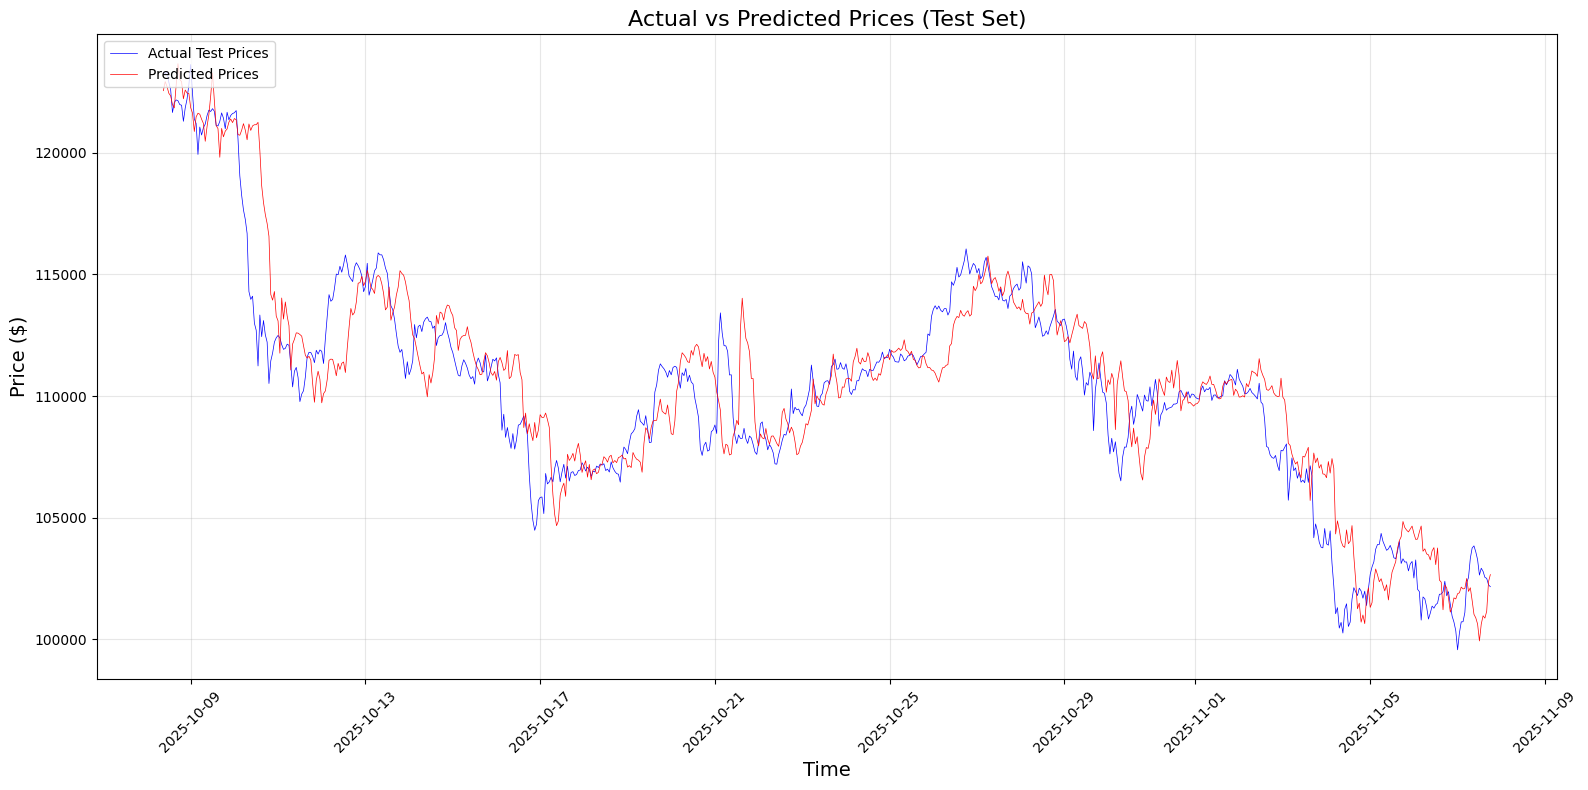

In [29]:
import matplotlib.pyplot as plt

# Plot test prices, predicted prices, and training prices
plt.figure(figsize=(16, 8))

# Plotting actual test prices (in blue)
plt.plot(metadata['test_time_indices'], Y_test_prices, label="Actual Test Prices", color='blue', linestyle='-', linewidth=0.5)

# Plotting predicted prices (in red)
plt.plot(metadata['test_time_indices'], Y_pred_prices, label="Predicted Prices", color='red', linestyle='-', linewidth=0.5)

# Adding titles and labels
plt.title('Actual vs Predicted Prices (Test Set)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(loc='upper left')

# Show grid
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for clarity
plt.xticks(rotation=45)

# Tight layout for better display
plt.tight_layout()

# Show plot
plt.show()
